<a href="https://colab.research.google.com/github/thiagotandrade/ds_project/blob/master/DS_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO: 

# 1.   VISUALIZAR A DISPERSÃO DOS ERROS




# Competição do Kaggle: [Zillow Prize](https://www.kaggle.com/c/zillow-prize-1)

# Initial Setup

In [0]:
import os
import warnings
import xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score

%matplotlib inline
warnings.filterwarnings("ignore")

In [0]:
props = pd.read_csv('https://raw.githubusercontent.com/thiagotandrade/ds_project/master/Database/merged_2016v2.csv',
                             header=0, sep=',', quotechar='"')

In [3]:
props.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,17073783,NaN,NaN,NaN,2.5,3.0,NaN,NaN,2.5,NaN,548.0,1264.0,1264.0,NaN,NaN,548.0,NaN,6111.0,NaN,2.0,2.0,0.0,NaN,NaN,34303597.0,-119287236.0,1735.0,NaN,NaN,NaN,NaN,NaN,1128,265.0,NaN,6.111002e+07,34543.0,2061.0,NaN,97081.0,5.0,NaN,1.0,NaN,NaN,128.0,NaN,1986.0,2.0,NaN,115087.0,191811.0,2015.0,76724.0,2015.06,NaN,NaN,6.111002e+13,0.0953,2016-01-27
1,17088994,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,777.0,777.0,777.0,NaN,NaN,777.0,NaN,6111.0,NaN,1.0,1.0,0.0,NaN,NaN,34272866.0,-119198911.0,NaN,NaN,NaN,NaN,NaN,NaN,1129,266.0,NaN,6.111002e+07,34543.0,2061.0,NaN,97083.0,4.0,NaN,NaN,NaN,NaN,198.0,NaN,1990.0,1.0,NaN,143809.0,239679.0,2015.0,95870.0,2581.30,NaN,NaN,6.111002e+13,0.0198,2016-03-30
2,17100444,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,1101.0,1101.0,1101.0,NaN,NaN,1101.0,NaN,6111.0,NaN,2.0,2.0,441.0,NaN,NaN,34340801.0,-119079610.0,6569.0,NaN,NaN,NaN,NaN,NaN,1111,261.0,NaN,6.111001e+07,26965.0,2061.0,NaN,97113.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1956.0,1.0,NaN,33619.0,47853.0,2015.0,14234.0,591.64,NaN,NaN,6.111001e+13,0.0060,2016-05-27
3,17102429,NaN,NaN,NaN,1.5,2.0,NaN,NaN,1.5,NaN,1554.0,1554.0,1554.0,NaN,NaN,1554.0,NaN,6111.0,1.0,1.0,2.0,460.0,NaN,NaN,34354313.0,-119076405.0,7400.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,26965.0,2061.0,NaN,97113.0,5.0,NaN,1.0,NaN,NaN,NaN,NaN,1965.0,1.0,NaN,45609.0,62914.0,2015.0,17305.0,682.78,NaN,NaN,6.111001e+13,-0.0566,2016-06-07
4,17109604,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,1305.0,2415.0,2415.0,NaN,NaN,1305.0,NaN,6111.0,1.0,2.0,2.0,665.0,NaN,NaN,34266578.0,-119165392.0,6326.0,NaN,NaN,NaN,NaN,NaN,1111,261.0,NaN,6.111001e+07,34543.0,2061.0,NaN,97084.0,8.0,NaN,1.0,NaN,NaN,NaN,NaN,1984.0,2.0,NaN,277000.0,554000.0,2015.0,277000.0,5886.92,NaN,NaN,6.111001e+13,0.0573,2016-08-08


# Definição de tipos

In [4]:
props['transactiondate'].head()

0    2016-01-27
1    2016-03-30
2    2016-05-27
3    2016-06-07
4    2016-08-08
Name: transactiondate, dtype: object

In [0]:
object_type = props.select_dtypes(include=['object']).columns.values
props[object_type] = props[object_type].astype('category')

#Mudar tipo da coluna transaction date para 'datetime64' e separando a data em colunas
props['transactiondate'] = pd.to_datetime(props['transactiondate'])
props['transaction_year'] = props['transactiondate'].dt.year
props['transaction_month'] = props['transactiondate'].dt.month
props['transaction_day'] = props['transactiondate'].dt.day
props.drop(['transactiondate'], axis=1, inplace=True)

# Remoção de dados ausentes

In [0]:
#A coluna 'fireplaceflag' não adiciona nenhuma informação útil pois o dataset já possui 'fireplacecnt', então removemos:
props.drop(['fireplaceflag'], axis=1, inplace=True)

#A coluna 'calculatedbathnbr' é uma cópia da coluna 'bathroomcnt', então removemos:
props.drop(['calculatedbathnbr'], axis=1, inplace=True)

#A coluna 'calculatedfinishedsquarefeet' é uma cópia da coluna 'finishedsquarefeet12', então removemos:
props.drop(['calculatedfinishedsquarefeet'], axis=1, inplace=True)

# Remover colunas com mais de 70% de dados ausentes
props.dropna(thresh=0.70*len(props), axis=1, inplace=True)

props.dropna(inplace=True)

In [7]:
props.shape

(73972, 27)

In [8]:
props.isnull().values.any()

False

In [9]:
props.head()

,parcelid,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transaction_year,transaction_month,transaction_day
0,17073783,2.5,3.0,1264.0,6111.0,2.0,34303597.0,-119287236.0,1735.0,1128,265.0,6.111002e+07,34543.0,2061.0,97081.0,5.0,1986.0,115087.0,191811.0,2015.0,76724.0,2015.06,6.111002e+13,0.0953,2016,1,27
2,17100444,2.0,3.0,1101.0,6111.0,2.0,34340801.0,-119079610.0,6569.0,1111,261.0,6.111001e+07,26965.0,2061.0,97113.0,5.0,1956.0,33619.0,47853.0,2015.0,14234.0,591.64,6.111001e+13,0.0060,2016,5,27
3,17102429,1.5,2.0,1554.0,6111.0,1.0,34354313.0,-119076405.0,7400.0,1110,261.0,6.111001e+07,26965.0,2061.0,97113.0,5.0,1965.0,45609.0,62914.0,2015.0,17305.0,682.78,6.111001e+13,-0.0566,2016,6,7
4,17109604,2.5,4.0,2415.0,6111.0,2.0,34266578.0,-119165392.0,6326.0,1111,261.0,6.111001e+07,34543.0,2061.0,97084.0,8.0,1984.0,277000.0,554000.0,2015.0,277000.0,5886.92,6.111001e+13,0.0573,2016,8,8
5,17125829,2.5,4.0,2882.0,6111.0,2.0,34240014.0,-119024793.0,10000.0,1111,261.0,6.111005e+07,51239.0,2061.0,97089.0,8.0,1980.0,222070.0,289609.0,2015.0,67539.0,3110.44,6.111005e+13,0.0564,2016,8,26


# Definição de Tipos

# Normalizando dados

# Separando em conjuntos de treinamento e teste

In [0]:
X = props.drop(['logerror'],axis=1)
y = props['logerror']

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

# Linear Regressor para servir como baseline

In [0]:
def linearRegressor(X_train, Y_train, X_test):
  regressor = LinearRegression(fit_intercept=True)

  model = regressor.fit(X_train, Y_train)

  pred_LR = regressor.predict(X_test)
  
  plt.scatter(Y_test, pred_LR)
  plt.xlabel("True Values")
  plt.ylabel("Predictions")
  
  print ("Score: {}".format(model.score(X_test, Y_test)))

  mae_LR = mean_absolute_error(Y_test, pred_LR)
  print ("Erro médio absoluto: {}".format(mae_LR))
  
  #Acurácia do modelo
  r2_LR = r2_score(Y_test, predictions)
  print ("Índice R²: {}".format(r2_LR))

# Random Forest Regressor

In [0]:
def randomForestRegressor(X_train, Y_train, X_test):
  # Gerar conjuntos de validação-cruzada para o treinamento de dados
  cv_sets = ShuffleSplit(n_splits=10, test_size = 0.25)

  #n_estimators =10
  rfr =  RandomForestRegressor(n_estimators=10, random_state=42)

  #Gerar um dicionário para o parâmetro 'max_depth' com um alcance de 1 a 10
  params ={'max_depth': list(range(1,10))}

  #Transformar 'performance_metric' em uma função de pontuação utilizando 'make_scorer' 
  scoring_fnc = make_scorer(mean_absolute_error)

  # Gerar o objeto de busca em matriz
  grid = GridSearchCV(rfr, params, scoring=scoring_fnc, cv=cv_sets)

  # Ajustar o objeto de busca em matriz com os dados para calcular o modelo ótimo
  grid = grid.fit(X_train, Y_train)

  # Escolher o melhor estimador para predizer os dados de teste
  best_rfr = grid.best_estimator_

  predictions = best_rfr.predict(X_test)
  
  
  ########## RESULTADOS ##########
  
  #calculando o erro de uma árvore de decisão para regressão:
  mae_RFR = mean_absolute_error(Y_test, predictions)
  print ("Erro médio absoluto: {}".format(mae_RFR))

  #Acurácia do modelo
  r2_RFR = r2_score(Y_test, predictions)
  print ("Índice R²: {}".format(r2_RFR))

### Filtrando dataset em relação ao munícipio com mais propriedades

### Encontrando o município que possui mais propriedades

In [14]:
props.propertycountylandusecode.value_counts()[props.propertycountylandusecode.value_counts() >0]

0100    29930
122     14792
010C     9366
0101     7159
1111     3825
010E     2141
010D     1982
1        1106
1110     1065
1129      467
34        443
1128      339
0104      337
012C      222
01DC      205
01HC      105
0103       97
010G       77
010H       71
010M       57
0700       45
0108       44
010F       28
010V       18
0109       17
1116        8
070D        5
0110        4
0102        3
012E        2
0200        2
0400        1
0131        1
0130        1
0300        1
010         1
38          1
0111        1
105         1
200         1
0114        1
Name: propertycountylandusecode, dtype: int64

In [15]:
props.propertycountylandusecode.value_counts().argmax()

'0100'

### props_county são as propriedades do município que contém mais casas

In [0]:
props_county = props[props.propertycountylandusecode == props.propertycountylandusecode.value_counts().argmax()]
props_county.drop(['propertycountylandusecode'], axis=1, inplace=True)

In [17]:
props_county.head()

,parcelid,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transaction_year,transaction_month,transaction_day
27,10727091,2.0,3.0,1160.0,6037.0,2.0,34188121.0,-118646361.0,7688.0,261.0,6.037135e+07,12447.0,3101.0,96342.0,0.0,1960.0,105045.0,437584.0,2015.0,332539.0,5421.96,6.037135e+13,0.0030,2016,10,14
28,10730788,2.0,4.0,1570.0,6037.0,2.0,34188446.0,-118616724.0,11308.0,261.0,6.037135e+07,12447.0,3101.0,96342.0,0.0,1959.0,115379.0,397138.0,2015.0,281759.0,5097.78,6.037135e+13,-0.0020,2016,7,1
32,10760933,2.0,4.0,1212.0,6037.0,2.0,34220631.0,-118521001.0,7379.0,261.0,6.037131e+07,12447.0,3101.0,96355.0,0.0,1954.0,32615.0,56867.0,2015.0,24252.0,4560.02,6.037131e+13,-0.1244,2016,6,27
33,10772282,3.0,4.0,2597.0,6037.0,3.0,34209413.0,-118578052.0,10537.0,261.0,6.037134e+07,12447.0,3101.0,96341.0,0.0,1964.0,234987.0,391643.0,2015.0,156656.0,4998.86,6.037134e+13,0.0545,2016,4,15
34,10783331,2.0,3.0,1742.0,6037.0,2.0,34185891.0,-118550426.0,7076.0,261.0,6.037133e+07,12447.0,3101.0,96364.0,0.0,1953.0,192864.0,471448.0,2015.0,278584.0,5784.98,6.037133e+13,0.0070,2016,2,25


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(props_county.drop(['logerror'], axis=1), props_county.logerror, test_size=1/3, random_state=42)

In [19]:
randomForestRegressor(X_train, Y_train, X_test)

Erro médio absoluto: 0.07789385291915603
Índice R²: -0.015460890108153436


Score: 0.0017412121369541067
Erro médio absoluto: 0.0763891960655751


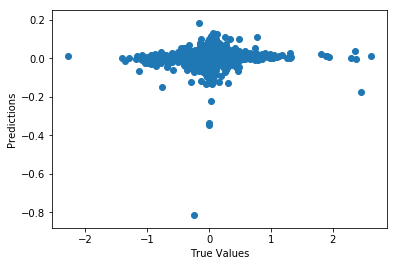

In [21]:
linearRegressor(X_train, Y_train, X_test)